# 이항분류(로지스틱)

## #01. 패키지 준비하기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터셋 준비하기

In [4]:
origin = pd.read_excel('https://data.hossam.kr/F03/pima-indians.xlsx')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


> Outcome = 종속변수 (0,1로 이루어진 이항분류 실시)

## #03. 데이터 전처리

### 결측치 확인

In [5]:
origin.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

> 결측치는 없는 것으로 확인

### 명목형변수 카테고리형 변환

In [6]:
origin['Outcome'] = origin['Outcome'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


## #04. 탐색적 데이터 분석 (for 데이터 분포 확인)
### 기초통계량 확인

In [7]:
origin.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


> 평균 간 분포 차이가 확인된다

### 상자그림 확인

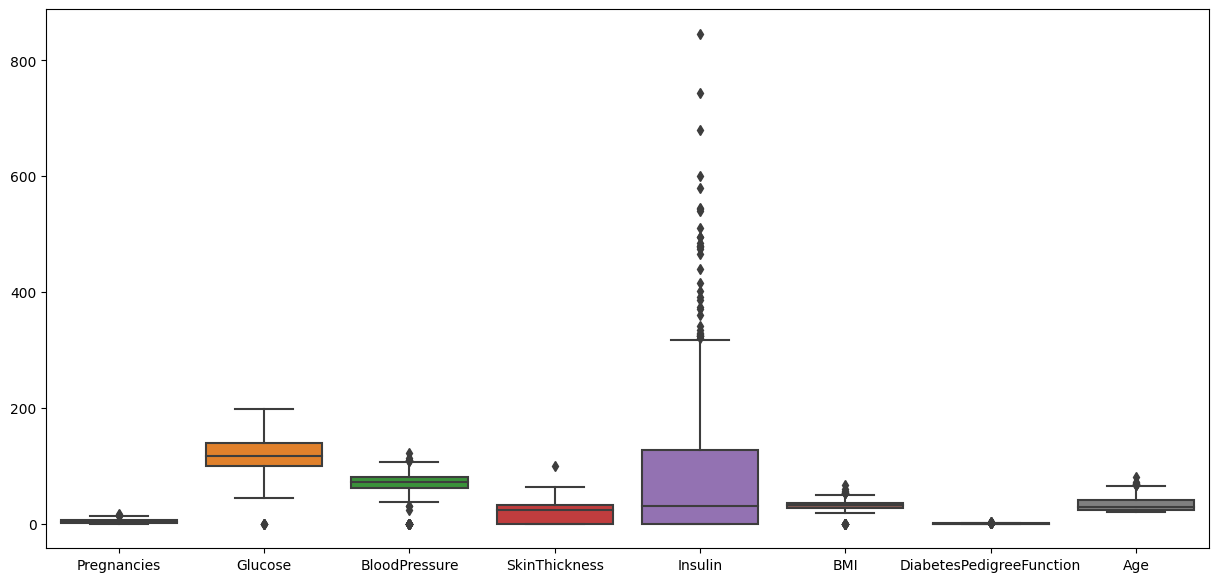

In [9]:
plt.figure(figsize=(15,7))
sb.boxplot(origin)
plt.show()
plt.close()

> 칼럼 간 데이터 분포가 상이하다 => 표준화 실시해야 할 듯!

## #05. 데이터셋 분리
### 랜덤시드 고정

In [10]:
np.random.seed(777)

### 훈련데이터와 레이블 분리

In [13]:
x = origin.drop('Outcome', axis=1)
y = origin[['Outcome']]
print(x.shape, y.shape)

(768, 8) (768, 1)


> 768 row, 8 columns / 768 row, 1 column

### 데이터 분포 상이 => 표준화

In [14]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x)
x_scale_df = pd.DataFrame(x_scale, index=x.index, columns= x.columns )
x_scale_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


### 훈련데이터와 검증데이터 분할

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((537, 8), (231, 8), (537, 1), (231, 1))

## #06. 모델 생성

In [17]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(x_train.columns), )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                288       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), 
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                              ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001, verbose=1)])

Epoch 1/500
17/17 [==============================] - 1s 13ms/step - loss: 4.9049 - acc: 0.4711 - val_loss: 1.8654 - val_acc: 0.6450 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 3ms/step - loss: 2.0285 - acc: 0.5605 - val_loss: 1.4964 - val_acc: 0.6710 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 3ms/step - loss: 1.8668 - acc: 0.5717 - val_loss: 1.3949 - val_acc: 0.6926 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 4ms/step - loss: 1.6377 - acc: 0.5885 - val_loss: 1.5763 - val_acc: 0.5325 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 3ms/step - loss: 1.5243 - acc: 0.5903 - val_loss: 1.3552 - val_acc: 0.6017 - lr: 0.0010
Epoch 6/500
17/17 [==============================] - 0s 5ms/step - loss: 1.3737 - acc: 0.5978 - val_loss: 1.1205 - val_acc: 0.6147 - lr: 0.0010
Epoch 7/500
17/17 [==============================] - 0s 3ms/step - loss: 1.2945 - acc: 0.5959 - val_loss: 1.0433 - val_acc: 0.6494 - lr

## #07. 학습결과 평가

In [25]:
# 결과 데이터프레임 만들기
result_df = pd.DataFrame(result.history)
result_df.head()

,loss,acc,val_loss,val_acc,lr
0,4.904950,0.471136,1.865389,0.645022,0.001
1,2.028527,0.560521,1.496405,0.670996,0.001
2,1.866788,0.571695,1.394948,0.692641,0.001
3,1.637715,0.588454,1.576350,0.532468,0.001
4,1.524272,0.590317,1.355168,0.601732,0.001


In [26]:
# 에폭스 추가
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df.head()

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,4.904950,0.471136,1.865389,0.645022,0.001
2,2.028527,0.560521,1.496405,0.670996,0.001
3,1.866788,0.571695,1.394948,0.692641,0.001
4,1.637715,0.588454,1.576350,0.532468,0.001
5,1.524272,0.590317,1.355168,0.601732,0.001


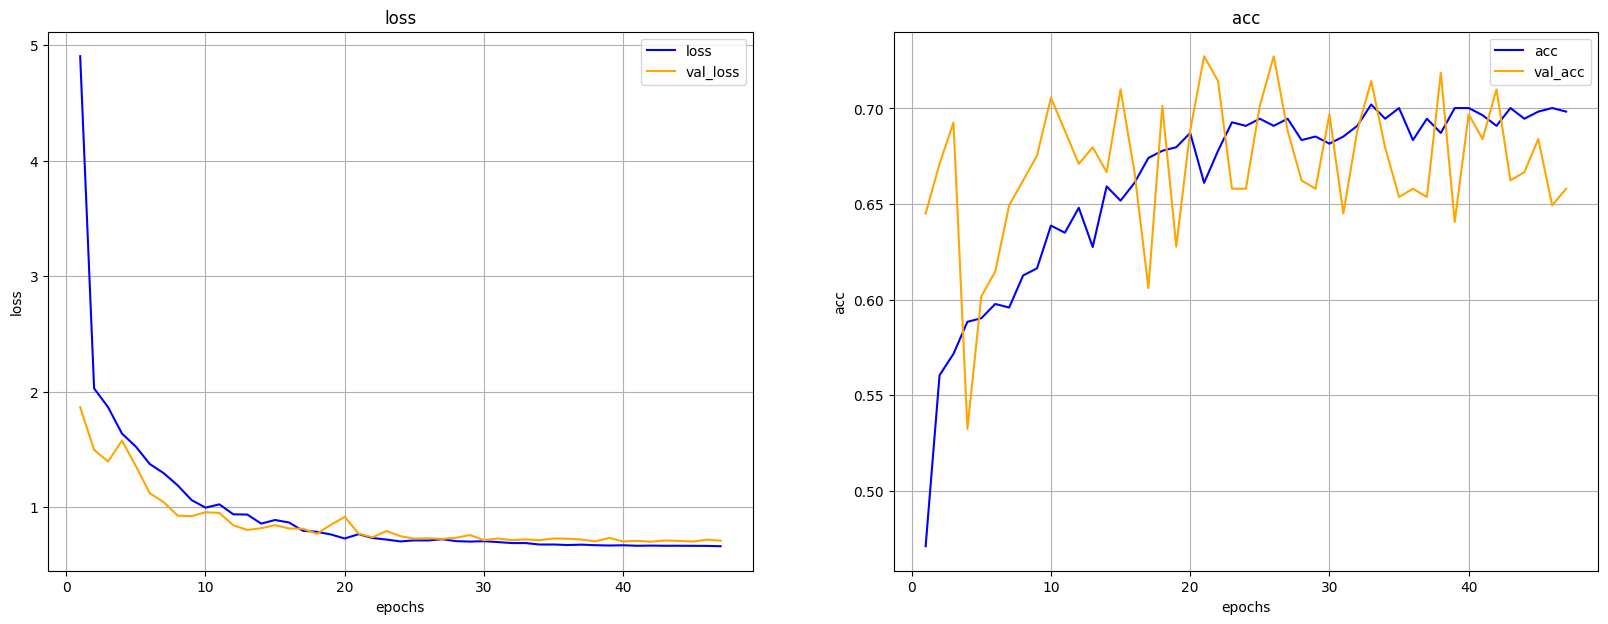

In [28]:
# 학습 결과 그래프의 컬럼명
column_names = result_df.columns

# 학습데이터에 대한 필드이름
train_column_name = [column_names[0], column_names[1]]
# 검증데이터에 대한 필드이름
test_column_name = [column_names[2], column_names[3]]

# 학습 결과 그래프
fig, ax = plt.subplots(1,2, figsize=(20,7))

for i, v in enumerate(ax):
    sb.lineplot(data=result_df, x=result_df.index, y=train_column_name[i], color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(data=result_df, x=result_df.index, y=test_column_name[i], color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('epochs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [29]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률 : %f, 최종 훈련 정확도 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률 : %f, 최종 검증 정확도 : %f" % (evaluate2[0], evaluate2[1]))

17/17 [==============================] - 0s 1ms/step - loss: 0.6548 - acc: 0.6983
최종 훈련 손실률 : 0.654813, 최종 훈련 정확도 : 0.698324
8/8 [==============================] - 0s 1ms/step - loss: 0.7098 - acc: 0.6580
최종 검증 손실률 : 0.709752, 최종 검증 정확도 : 0.658009


## #08. 학습결과 적용

### 테스트 데이터에 대한 예측결과 산정

In [32]:
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print("%d개의 훈련데이터가 %d개의 경우의 수를 갖는다" % (data_count, case_count))
print(train_pred)

 1/17 [>.............................] - ETA: 0s

17/17 [==============================] - 0s 1ms/step
537개의 훈련데이터가 1개의 경우의 수를 갖는다
[[0.7114888 ]
 [0.7960293 ]
 [0.57850814]
 [0.13827081]
 [0.42015874]
 [0.16773948]
 [0.21702214]
 [0.7034052 ]
 [0.34533092]
 [0.5468189 ]
 [0.71729213]
 [0.34791383]
 [0.5332932 ]
 [0.15839235]
 [0.5287546 ]
 [0.39020208]
 [0.10507654]
 [0.30291566]
 [0.07880615]
 [0.20139489]
 [0.3450562 ]
 [0.19549759]
 [0.1746713 ]
 [0.46912473]
 [0.49685034]
 [0.26563925]
 [0.8602867 ]
 [0.2135113 ]
 [0.79490936]
 [0.26057938]
 [0.08543427]
 [0.25397378]
 [0.2232925 ]
 [0.6646523 ]
 [0.9681028 ]
 [0.7581689 ]
 [0.2013202 ]
 [0.3009688 ]
 [0.4019485 ]
 [0.13888653]
 [0.24685657]
 [0.02535915]
 [0.01113941]
 [0.5774779 ]
 [0.30383745]
 [0.5378932 ]
 [0.08268655]
 [0.72341   ]
 [0.21773858]
 [0.2531791 ]
 [0.1867688 ]
 [0.11025137]
 [0.15501373]
 [0.77949595]
 [0.5313691 ]
 [0.5451481 ]
 [0.569143  ]
 [0.48697856]
 [0.5117556 ]
 [0.10605998]
 [0.04603255]
 [0.6678888 ]
 [0.7967787 ]
 [0.4353751 ]
 [0.31472105]
 [0.82048

In [33]:
train_df = pd.DataFrame({
    '관측치' : y_train['Outcome'],
    '예측치': np.round(train_pred.flatten())
})

train_df

,관측치,예측치
335,0,1.0
130,1,1.0
255,1,1.0
573,0,0.0
764,0,0.0
...,...,...
669,0,0.0
71,0,1.0
599,0,0.0
571,0,0.0


### 검증데이터에 대한 예측결과 산정

In [34]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증데이터가 %d개의 경우의 수를 갖는다" % (data_count, case_count))
print(test_pred)

8/8 [==============================] - 0s 1ms/step
231개의 검증데이터가 1개의 경우의 수를 갖는다
[[7.04444945e-02]
 [3.75248753e-02]
 [8.64391625e-01]
 [4.10632968e-01]
 [6.51259422e-01]
 [5.21314323e-01]
 [4.02078152e-01]
 [3.57352823e-01]
 [3.56211692e-01]
 [6.13591075e-01]
 [4.49980795e-02]
 [1.44577503e-01]
 [3.07912111e-01]
 [1.33574381e-01]
 [1.69773713e-01]
 [1.22028150e-01]
 [2.42764130e-01]
 [3.32203716e-01]
 [7.54880369e-01]
 [1.58657283e-01]
 [2.04523340e-01]
 [2.48236105e-01]
 [7.65368342e-01]
 [5.82776964e-02]
 [3.46073389e-01]
 [2.97400355e-01]
 [2.32403070e-01]
 [9.28733170e-01]
 [3.41776252e-01]
 [2.14870870e-01]
 [1.24460720e-01]
 [7.06129432e-01]
 [5.37611544e-01]
 [1.12880366e-02]
 [3.54685515e-01]
 [2.44672280e-02]
 [1.85266316e-01]
 [5.60531259e-01]
 [1.79503277e-01]
 [2.37021223e-01]
 [1.29056349e-01]
 [4.80209142e-01]
 [2.33702719e-01]
 [8.45338762e-01]
 [6.50140405e-01]
 [5.18335640e-01]
 [3.29419672e-01]
 [2.21482173e-01]
 [6.28045797e-02]
 [2.31438220e-01]
 [7.58604705e-01]
 [2

In [35]:
test_df = pd.DataFrame({
    '관측치': y_test['Outcome'],
    '예측치' : np.round(test_pred.flatten())
})

test_df

,관측치,예측치
387,1,0.0
43,1,0.0
408,1,1.0
262,0,0.0
533,0,1.0
...,...,...
46,0,1.0
290,0,0.0
418,0,0.0
434,0,0.0


### 결과 확인

#### 1) 훈련데이터

##### 예측값 생성

In [36]:
pred_bool = model.predict(x_train).flatten() > 0.5
pred = pred_bool.astype(int)
pred

17/17 [==============================] - 0s 502us/step


array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,

##### 혼동행렬 구하기

In [37]:
from sklearn.metrics import confusion_matrix

In [40]:
cm = confusion_matrix(y_train, pred)
tn, fp, fn, tp = cm.ravel()
cmdf = pd.DataFrame([[tn, fn], [fp, tp]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf

,Negative,Positive
True,262,83
False,79,113


##### 위양성율, 재현율, 정확도, 정밀도, F1 score

In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

In [49]:
result_df2 = pd.DataFrame({
    '정확도' : (tp + tn)/(tp+tn+fp+fn),
    '정밀도': tp/(tp+fp),
    '재현율(Recall, TPR)': tp/(tp+fn),
    '위양성율(Fallout, FPR)' : fp / (fp+tn),
    '특이성(Specificity, TNR)' : 1 - (fp / (fp+tn)),
    'RAS' : roc_auc_score(y_train, pred),
    'f1_score': 2*((tp/(tp+fp))*tp/(tp+fn)) / ((tp/(tp+fp)) + tp/(tp+fn)),
}, index = result_df.index)

result_df2.head()

,정확도,정밀도,"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
epochs,,,,,,,
1,0.698324,0.588542,0.576531,0.231672,0.768328,0.67243,0.582474
2,0.698324,0.588542,0.576531,0.231672,0.768328,0.67243,0.582474
3,0.698324,0.588542,0.576531,0.231672,0.768328,0.67243,0.582474
4,0.698324,0.588542,0.576531,0.231672,0.768328,0.67243,0.582474
5,0.698324,0.588542,0.576531,0.231672,0.768328,0.67243,0.582474


In [52]:
result_df3 = pd.DataFrame({
    '정확도' : accuracy_score(y_train, pred),
    '정밀도': precision_score(y_train,pred),
    '재현율(Recall, TPR)':recall_score(y_train, pred),
    '위양성율(Fallout, FPR)' : fp / (fp+tn),
    '특이성(Specificity, TNR)' : 1 - (fp / (fp+tn)),
    'RAS' : roc_auc_score(y_train, pred),
    'f1_score': f1_score(y_train, pred)
}, index = result_df.index)

result_df3.head().T

epochs,1,2,3,4,5
정확도,0.698324,0.698324,0.698324,0.698324,0.698324
정밀도,0.588542,0.588542,0.588542,0.588542,0.588542
"재현율(Recall, TPR)",0.576531,0.576531,0.576531,0.576531,0.576531
"위양성율(Fallout, FPR)",0.231672,0.231672,0.231672,0.231672,0.231672
"특이성(Specificity, TNR)",0.768328,0.768328,0.768328,0.768328,0.768328
RAS,0.672430,0.672430,0.672430,0.672430,0.672430
f1_score,0.582474,0.582474,0.582474,0.582474,0.582474


##### 오즈비 구하기

In [46]:
# 모델 가중치와 편향 얻기
weights, bias = model.layers[1].get_weights()

# 오즈비
odds_ratio = np.exp(weights[0])
odds_ratio

array([1.0650265], dtype=float32)

#### 2) 검증데이터
##### 예측값 생성

In [53]:
pred_bool2 = model.predict(x_test).flatten() > 0.5
pred2 = pred_bool2.astype(int)
pred2

8/8 [==============================] - 0s 1ms/step


array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

##### 혼동행렬 구하기

In [54]:
cm2 = confusion_matrix(y_test, pred2)
tn, fp, fn, tp = cm.ravel()
cmdf2 = pd.DataFrame([[tn, fn], [fp, tp]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf2

,Negative,Positive
True,262,83
False,79,113


##### 위양성율, 재현율, 정확도, 정밀도, F1 score

In [56]:
result_df4 = pd.DataFrame({
    '정확도' : (tp + tn)/(tp+tn+fp+fn),
    '정밀도': tp/(tp+fp),
    '재현율(Recall, TPR)': tp/(tp+fn),
    '위양성율(Fallout, FPR)' : fp / (fp+tn),
    '특이성(Specificity, TNR)' : 1 - (fp / (fp+tn)),
    'RAS' : roc_auc_score(y_test, pred2),
    'f1_score': 2*((tp/(tp+fp))*tp/(tp+fn)) / ((tp/(tp+fp)) + tp/(tp+fn)),
}, index = result_df.index)

result_df4.head().T

epochs,1,2,3,4,5
정확도,0.698324,0.698324,0.698324,0.698324,0.698324
정밀도,0.588542,0.588542,0.588542,0.588542,0.588542
"재현율(Recall, TPR)",0.576531,0.576531,0.576531,0.576531,0.576531
"위양성율(Fallout, FPR)",0.231672,0.231672,0.231672,0.231672,0.231672
"특이성(Specificity, TNR)",0.768328,0.768328,0.768328,0.768328,0.768328
RAS,0.607180,0.607180,0.607180,0.607180,0.607180
f1_score,0.582474,0.582474,0.582474,0.582474,0.582474


In [57]:
result_df5 = pd.DataFrame({
    '정확도' : accuracy_score(y_test, pred2),
    '정밀도': precision_score(y_test,pred2),
    '재현율(Recall, TPR)':recall_score(y_test, pred2),
    '위양성율(Fallout, FPR)' : fp / (fp+tn),
    '특이성(Specificity, TNR)' : 1 - (fp / (fp+tn)),
    'RAS' : roc_auc_score(y_test, pred2),
    'f1_score': f1_score(y_test, pred2)
}, index = result_df.index)

result_df5.head().T

epochs,1,2,3,4,5
정확도,0.658009,0.658009,0.658009,0.658009,0.658009
정밀도,0.453333,0.453333,0.453333,0.453333,0.453333
"재현율(Recall, TPR)",0.472222,0.472222,0.472222,0.472222,0.472222
"위양성율(Fallout, FPR)",0.231672,0.231672,0.231672,0.231672,0.231672
"특이성(Specificity, TNR)",0.768328,0.768328,0.768328,0.768328,0.768328
RAS,0.607180,0.607180,0.607180,0.607180,0.607180
f1_score,0.462585,0.462585,0.462585,0.462585,0.462585


##### 오즈비 구하기

In [58]:
# 모델 가중치와 편향 얻기
weights, bias = model.layers[1].get_weights()

# 오즈비
odds_ratio = np.exp(weights[0])
odds_ratio

array([1.0650265], dtype=float32)